Load training images

Training images:


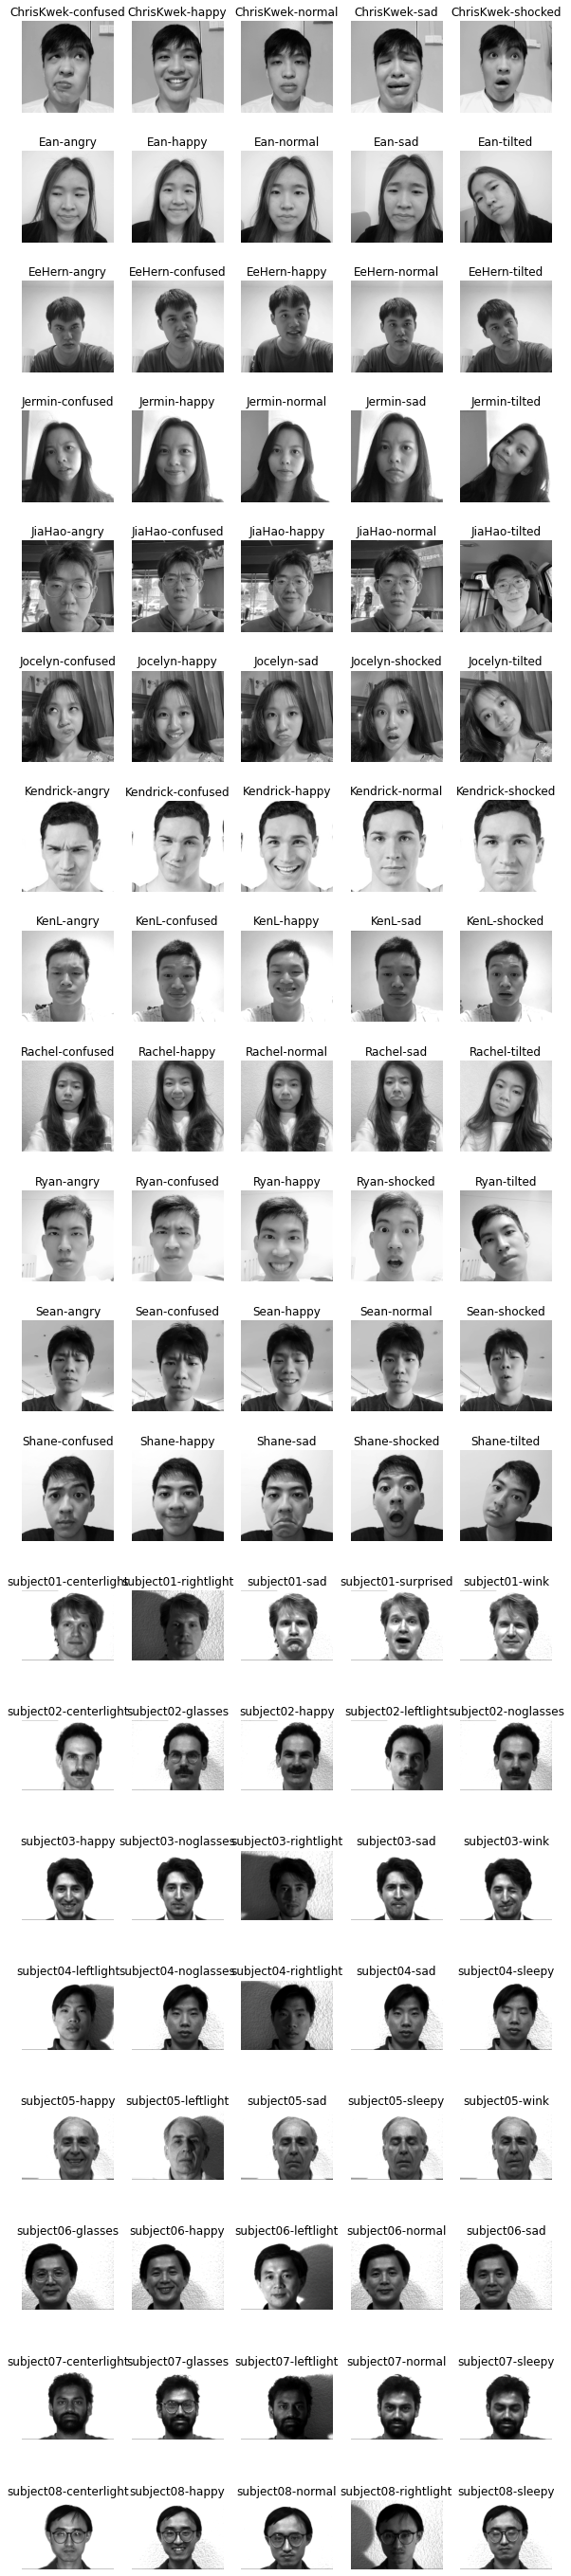

In [29]:
import numpy as np
import cv2
import dlib
import imutils
import os
import matplotlib.pyplot as plt

image_dir = "./Images/train/"
training_images = os.listdir(image_dir)

raw_image, raw_label = [], []
for image in training_images:
    # Load training image
    img = cv2.imread(image_dir + image)

    # Convert image to grayscale
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    raw_image.append(np.array(img))
    raw_label.append(image.split(".")[0])

# Plot the training images
fig, ax = plt.subplots(20, 5, figsize=(10, 50))
ax = ax.ravel()
for i in range(100):
    ax[i].imshow(raw_image[i], cmap='gray')
    ax[i].set_title(raw_label[i])
    ax[i].axis('off')
print("Training images:")
plt.show()

Detect face region using OpenCV

Face region detected:


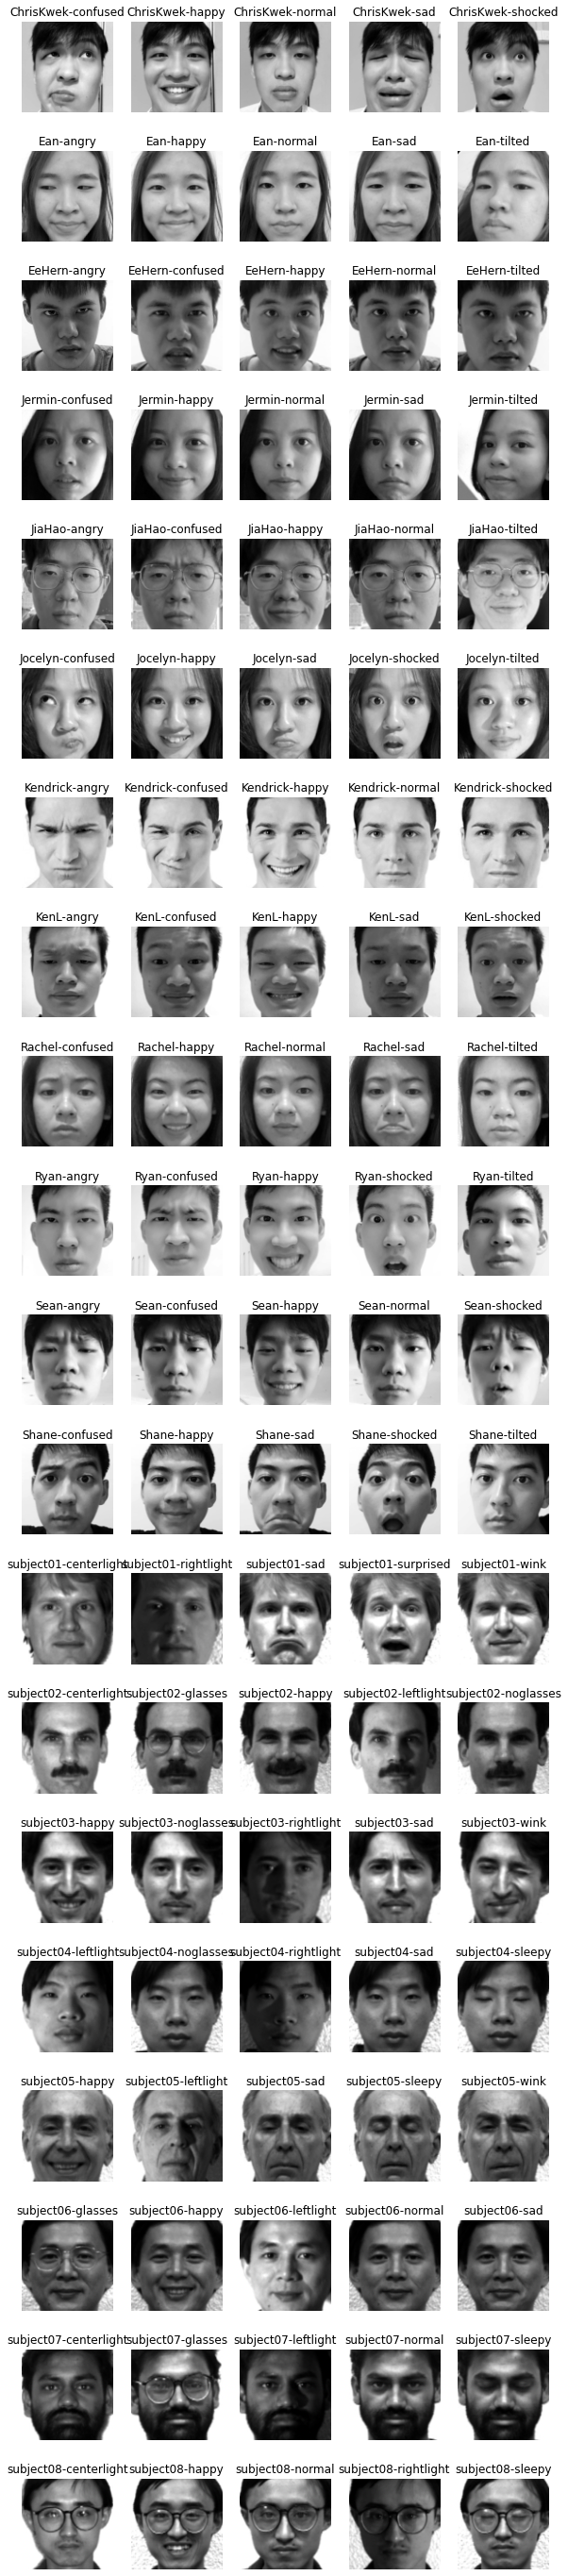

In [30]:
# Load the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Load the dlib face detector and 68 landmarks predictor model
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

# Function to align face
def align_face(image):
    image_copy = image.copy()
    image = imutils.resize(image, width=250)

    # Detect faces in the image
    faces = detector(image)
    if len(faces) == 0:
        return image_copy

    # Detect landmarks for the face
    landmarks = predictor(image, faces[0])
    
    # Compute the center point between the left and right eye landmarks
    left_eye = [(landmarks.part(i).x, landmarks.part(i).y) for i in range(36, 42)]
    right_eye = [(landmarks.part(i).x, landmarks.part(i).y) for i in range(42, 48)]
    left_eye_center = np.mean(left_eye, axis=0)
    right_eye_center = np.mean(right_eye, axis=0)
    eyes_center = ((left_eye_center[0] + right_eye_center[0]) // 2, (left_eye_center[1] + right_eye_center[1]) // 2)

    # Compute the rotation angle between the left and right eye landmarks
    rotation_angle = np.degrees(np.arctan2(right_eye_center[1] - left_eye_center[1], right_eye_center[0] - left_eye_center[0]))

    # Define the rotation matrix 
    M = cv2.getRotationMatrix2D(eyes_center, rotation_angle, 1.0)

    # Apply the transformation to the face
    h, w = image.shape[:2]
    aligned_face = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC)

    return aligned_face

face_image, face_label = [], []
for image, label in zip(raw_image, raw_label):
    # Align the face image
    rotated_img = align_face(image)

    # Detect the face region
    faces = face_cascade.detectMultiScale(rotated_img, scaleFactor=1.1, minNeighbors=5)

    # Resize the face to 100 x 100
    if len(faces) > 0: 
        x, y, w, h = faces[0]
        face_region = rotated_img[y:y+h, x:x+w]
        resized_face = cv2.resize(face_region, (100, 100), interpolation=cv2.INTER_AREA)
        face_image.append(resized_face.flatten())
        face_label.append(label)
face_image = np.array(face_image)

# Plot the face region
fig, ax = plt.subplots(20, 5, figsize=(10, 50))
ax = ax.ravel()
for i in range(100):
    ax[i].imshow(face_image[i].reshape(100, 100), cmap='gray')
    ax[i].set_title(face_label[i])
    ax[i].axis('off')
print("Face region detected:")
plt.show()

Training stage: Dimension reduction with PCA

Mean:


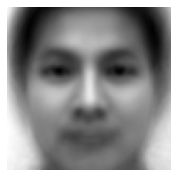

Mean adjusted data:


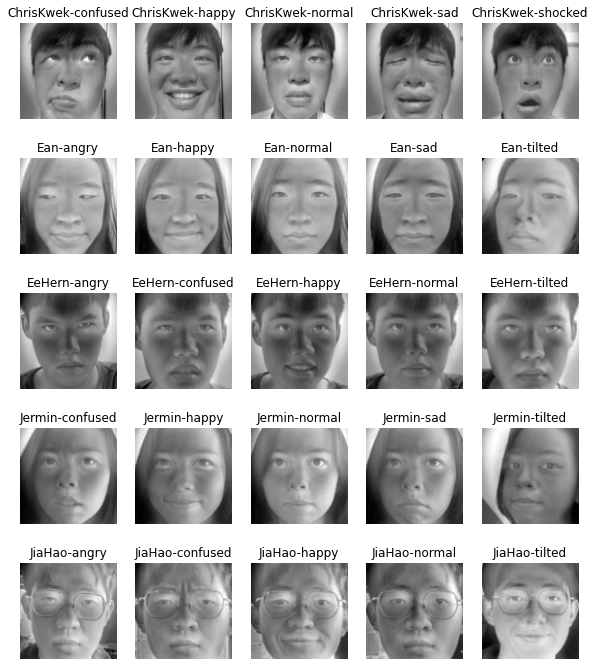

Top eigenvectors:


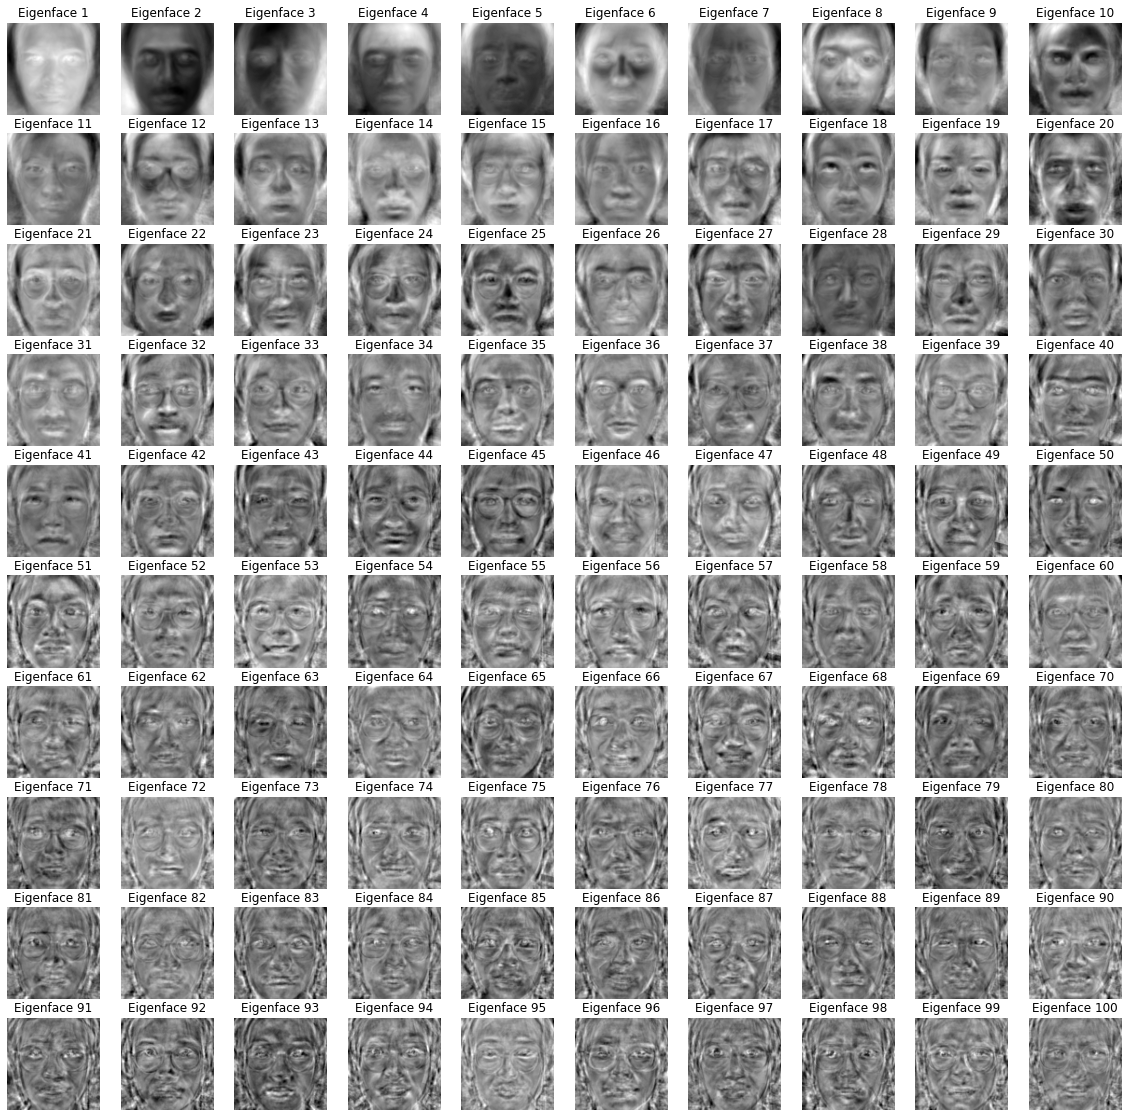

In [31]:
# Calculate the average face
f = face_image.transpose()
mean = np.mean(f, axis=1, keepdims=True)
print("Mean:")
plt.figure(figsize=(3, 3))
plt.imshow(mean.reshape(100, 100), cmap='gray')
plt.axis('off')
plt.show()

# Perform mean adjust on the data
X = f - mean
fig, ax = plt.subplots(5, 5, figsize=(10, 12))
ax = ax.ravel()
for i in range(25):
    ax[i].imshow(X.T[i].reshape(100, 100), cmap='gray')
    ax[i].set_title(face_label[i])
    ax[i].axis('off')
print("Mean adjusted data:")
plt.show()

# Calculate the covariance matrix
C = 1 / (X.shape[1]-1) * X @ X.T 

# Calculate the eigenvalues and eigenvectors of the covariance matrix
eigenvalues, eigenvectors = np.linalg.eigh(C)

# Sort the eigenvalues and eigenvectors in descending order
idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

# Select top 100 eigenvectors
selected_eigenvectors = eigenvectors[:, :100]
print("Top eigenvectors:")
fig, ax = plt.subplots(10, 10, figsize=(20, 20))
ax = ax.ravel()
for i in range(100):
    ax[i].imshow(np.real(selected_eigenvectors[:,i]).reshape(100, 100), cmap='gray')
    ax[i].set_title("Eigenface " + str(i+1))
    ax[i].axis('off')
plt.show()

# Project the face images onto the eigenspace
w_train = X.T @ selected_eigenvectors

Recognition stage

In [9]:
# # Capture image from the camera
# cam = cv2.VideoCapture(0)
# img_counter = 0

# while True:
#     result, frame = cam.read()
#     cv2.imshow("test", frame)
    
#     k = cv2.waitKey(1)
    
#     if k == ord("c"):
#         print("The camera is closed!")
#         break
        
#     elif k == ord("s"):
#         img_name = "./test/unknown_face_{}.png".format(img_counter)
#         cv2.imwrite(img_name, frame)
#         print("Screenshot is taken!")
#         img_counter += 1

# cam.release()
# cv2.destroyAllWindows()

In [34]:
# Load test images
image_dir = "./Images/test/"
test_images = os.listdir(image_dir)
raw_image_test, raw_label_test = [], []
for image in test_images:
    img = cv2.imread(image_dir + image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    raw_image_test.append(np.array(img))
    raw_label_test.append(image.split(".")[0])

# Detect face region
face_image_test, face_label_test = [], []
for image, label in zip(raw_image_test, raw_label_test):
    rotated_img = align_face(image)
    faces = face_cascade.detectMultiScale(rotated_img, scaleFactor=1.1, minNeighbors=5)
    if len(faces) > 0: 
        x, y, w, h = faces[0]
        face_region = rotated_img[y:y+h, x:x+w]
        resized_face = cv2.resize(face_region, (100, 100), interpolation=cv2.INTER_AREA)
        face_image_test.append(resized_face.flatten())
        face_label_test.append(label)
face_image_test = np.array(face_image_test)

Test results:


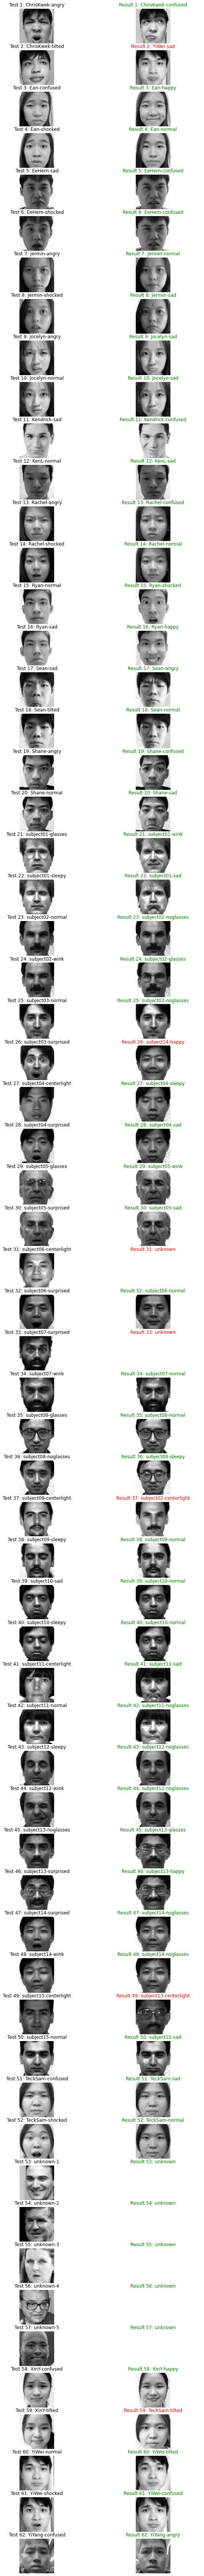

Number of correct predictions: 55 out of 62 samples.
Accuracy: 88.71%


In [35]:
# Project the test faces onto the eigenspace
f_test = face_image_test.transpose()
w_test = (f_test - mean).T @ selected_eigenvectors

predictions = []
num_correct = 0
threshold = 4500
fig, ax = plt.subplots(face_image_test.shape[0], 2, figsize=(10, 2*face_image_test.shape[0]))

for i in range(face_image_test.shape[0]):

    # Compute the distance between test and training data
    dist = np.linalg.norm(w_train-w_test[i], axis=1)

    # Identify unknown face based on recognition threshold
    if min(dist) > threshold:
        predictions.append('unknown')
    
    # Find the closest data from the training face images
    else: 
        pred = np.argmin(dist)
        predictions.append(face_label[pred])
    
    # Count the number of correct predictions
    if face_label_test[i].split('-')[0] == predictions[i].split('-')[0]:
        num_correct += 1

    # Display test results
    ax[i][0].imshow(face_image_test[i].reshape(100, 100), cmap='gray')
    ax[i][0].set_title(f"Test {i+1}: {face_label_test[i]}")
    ax[i][0].axis('off')
    if predictions[i] != 'unknown':
        ax[i][1].imshow(face_image[pred].reshape(100, 100), cmap='gray')
    ax[i][1].set_title(f"Result {i+1}: {predictions[i]}", color='green' 
if face_label_test[i].split('-')[0] == predictions[i].split('-')[0] else 'red')
    ax[i][1].axis('off')

print("Test results:")
plt.show()

# Calculate recognition accuracy
accuracy = num_correct / face_image_test.shape[0]
print(f"Number of correct predictions: {num_correct} out of {face_image_test.shape[0]} samples.")
print(f"Accuracy: {accuracy:.2%}")